# Customer Lifetime Value - ChatGPT Dataset

Import Libraries

In [3]:
import pandas as pd
import numpy as np

import joblib

!pip install plotnine
import plotnine as pn
from plotnine import ggplot, aes, geom_line, geom_point, facet_wrap

!pip install xgboost
from xgboost import XGBClassifier, XGBRegressor

from sklearn.model_selection import GridSearchCV

## Data Preparation

In [5]:
main_df = pd.read_csv("retail_data.csv")
main_df

,customer_id,date,price,quantity
0,2733,2023-10-07 13:44:44,419.79,1
1,2608,2023-03-09 02:15:40,174.77,9
2,1654,2023-09-24 08:34:24,464.57,4
3,3265,2023-05-31 18:08:12,355.88,2
4,4932,2024-03-05 17:19:31,335.13,8
...,...,...,...,...
59995,2559,2023-03-18 08:51:41,49.34,7
59996,4527,2023-02-03 05:59:45,477.74,9
59997,2995,2024-05-29 10:22:52,314.35,1
59998,4018,2023-12-27 02:48:33,96.70,3


In [6]:
main_df['customer_id'].nunique() # Number of Customers

5000

In [7]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  60000 non-null  int64  
 1   date         60000 non-null  object 
 2   price        60000 non-null  float64
 3   quantity     60000 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 1.8+ MB


In [8]:
# Change date type
main_df = main_df.assign(date = lambda x: x['date'].astype(str))
main_df = main_df.assign(date = lambda x: pd.to_datetime(x['date'])).dropna()
main_df = main_df.sort_values(['customer_id', 'date'])

## Cohort Analysis


In [10]:
# Initial purchance range

main_ip = main_df.sort_values(['customer_id', 'date']).groupby('customer_id').first()
main_ip

,date,price,quantity
customer_id,,,
1,2023-01-06 12:16:54,467.01,5
2,2023-03-24 16:51:32,164.38,8
3,2023-03-26 23:06:48,322.94,5
4,2023-03-31 02:27:31,53.47,9
5,2023-01-07 05:47:38,84.65,9
...,...,...,...
4996,2023-01-23 17:08:11,340.00,2
4997,2023-01-11 16:57:58,323.22,1
4998,2023-01-27 05:36:49,118.57,3


In [11]:
main_ip['date'].min()

Timestamp('2023-01-01 00:02:14')

In [12]:
main_ip['date'].max()

Timestamp('2024-02-01 03:14:51')

#### Visualize all purchases within cohort

<Axes: xlabel='date'>

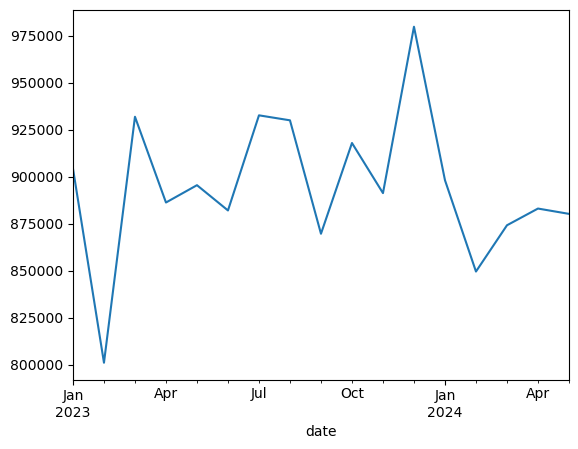

In [14]:
main_df.reset_index().set_index('date')['price'].resample(rule = "MS").sum().plot()

In [15]:
ids = main_df['customer_id'].unique()
ids_selected = ids[0:20]
ids_selected

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [16]:
main_cust_subset = main_df[main_df['customer_id'].isin(ids_selected)].groupby(['customer_id', 'date']).sum().reset_index()
main_cust_subset

,customer_id,date,price,quantity
0,1,2023-01-06 12:16:54,467.01,5
1,1,2023-01-16 08:16:42,454.89,6
2,1,2023-03-05 01:46:31,476.35,3
3,1,2023-03-25 10:48:45,142.21,8
4,1,2023-06-08 17:48:58,88.31,9
...,...,...,...,...
224,20,2024-01-18 04:02:24,84.71,1
225,20,2024-03-28 03:06:16,199.90,5
226,20,2024-04-03 02:18:39,434.36,6
227,20,2024-04-07 12:36:28,13.64,5


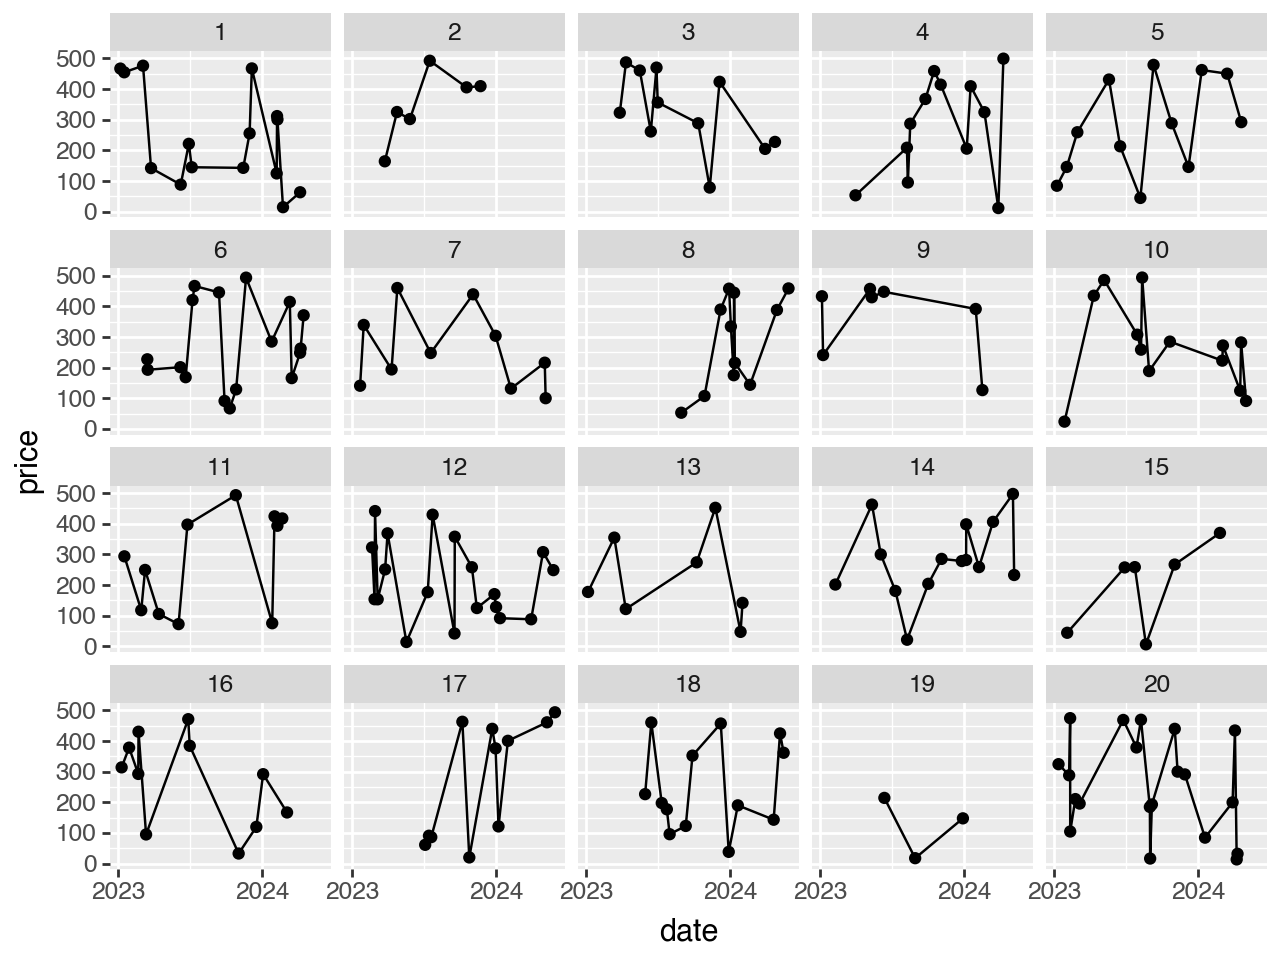

In [17]:
pn.ggplot(main_cust_subset, aes(x = 'date', y = 'price', group = 'customer_id')) + pn.geom_line() + pn.geom_point()\
    + pn.facet_wrap('customer_id') + pn.scale_x_date(date_breaks = "1 year", date_labels = "%Y")

## Machine Learning

- How much will the customer spend in next 90 days? (Regression)
- What is the probability of customer spending in the next 90 days? (Classisfication)


#### Time Splitting Stage

In [20]:
n_days = 90
max_date = main_df['date'].max()

cutoff = max_date - pd.to_timedelta(n_days, unit= "d")
cutoff

Timestamp('2024-03-01 23:39:46')

In [21]:
temporal_in_df = main_df[main_df['date'] <= cutoff]
temporal_in_df

,customer_id,date,price,quantity
19077,1,2023-01-06 12:16:54,467.01,5
605,1,2023-01-16 08:16:42,454.89,6
57152,1,2023-03-05 01:46:31,476.35,3
10019,1,2023-03-25 10:48:45,142.21,8
59840,1,2023-06-08 17:48:58,88.31,9
...,...,...,...,...
33883,5000,2023-09-09 22:45:25,378.76,1
4817,5000,2023-11-11 10:12:41,332.81,1
51996,5000,2023-11-28 23:15:14,342.77,7
11639,5000,2023-12-28 05:42:08,207.70,6


In [22]:
temporal_out_df = main_df[main_df['date'] > cutoff]
temporal_out_df

,customer_id,date,price,quantity
57509,1,2024-04-06 18:32:17,63.44,4
55890,3,2024-03-29 20:29:15,204.92,8
2538,3,2024-04-23 19:39:44,227.77,2
39526,4,2024-03-27 14:55:15,11.86,2
2872,4,2024-04-09 11:59:52,499.37,6
...,...,...,...,...
59151,4998,2024-05-10 09:47:56,155.64,7
24864,4999,2024-04-28 16:14:35,395.19,1
51537,4999,2024-05-30 13:33:06,147.06,4
50671,5000,2024-03-07 04:30:32,33.38,7


#### Feature Engineering (RFM)

Make targets from out data

In [24]:
target_df = temporal_out_df.drop(['quantity', 'date'], axis = 1).groupby('customer_id').sum().rename({'price':'spend_90_total'}, axis = 1)\
            .assign(spend_90_flag = 1)
target_df

,spend_90_total,spend_90_flag
customer_id,,
1,63.44,1
3,432.69,1
4,511.23,1
5,742.62,1
6,1463.15,1
...,...,...
4996,513.98,1
4997,437.75,1
4998,345.55,1


In [26]:
max_date = temporal_in_df['date'].max()
max_date

Timestamp('2024-03-01 23:30:33')

In [27]:
recency_df = temporal_in_df[['customer_id', 'date']].groupby('customer_id')\
                .apply(lambda x: (x['date'].max() - max_date) / pd.to_timedelta(1, "day")).to_frame().set_axis(["Recency"], axis = 1)
recency_df

/var/folders/4j/5_q1_j096m30w8450rgfrcph0000gn/T/ipykernel_16072/1288035169.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,Recency
customer_id,
1,-7.681563
2,-100.434329
3,-87.737361
4,-9.626620
5,-52.077280
...,...
4996,-7.757326
4997,-9.770775
4998,-56.904988


Frequency (Count)

- Number of Customer's purchases

In [29]:
frequency_df = frequency_df = temporal_in_df[['customer_id', 'date']].groupby('customer_id').count().set_axis(["Frequency"], axis = 1)
frequency_df

,Frequency
customer_id,
1,14
2,6
3,9
4,10
5,10
...,...
4996,9
4997,15
4998,11


Monetary (Price)

- Total Customer spending amount

In [31]:
monetary_df = temporal_in_df.groupby('customer_id')\
                .aggregate ({'price' : ["sum", "mean"]}).set_axis(["price_sum", "price_mean"], axis = 1)
monetary_df

,price_sum,price_mean
customer_id,,
1,3613.69,258.120714
2,2099.84,349.973333
3,3150.22,350.024444
4,2825.68,282.568000
5,2555.14,255.514000
...,...,...
4996,3111.53,345.725556
4997,3934.06,262.270667
4998,2323.88,211.261818


Combine all Features

In [33]:
features_df = pd.concat([recency_df, frequency_df, monetary_df], axis = 1)\
                .merge(target_df, left_index = True, right_index = True, how = "left").fillna(0)
features_df

,Recency,Frequency,price_sum,price_mean,spend_90_total,spend_90_flag
customer_id,,,,,,
1,-7.681563,14,3613.69,258.120714,63.44,1.0
2,-100.434329,6,2099.84,349.973333,0.00,0.0
3,-87.737361,9,3150.22,350.024444,432.69,1.0
4,-9.626620,10,2825.68,282.568000,511.23,1.0
5,-52.077280,10,2555.14,255.514000,742.62,1.0
...,...,...,...,...,...,...
4996,-7.757326,9,3111.53,345.725556,513.98,1.0
4997,-9.770775,15,3934.06,262.270667,437.75,1.0
4998,-56.904988,11,2323.88,211.261818,345.55,1.0


## Machine Learning

In [35]:
# Regressors

X = features_df[['Recency', 'Frequency', 'price_sum', 'price_mean']]

#### Next 90 Day Spend Prediction

- How Much Amount is the Customer Going to Spend in the next 90 Days

In [37]:
# Target Variable

y_spend = features_df['spend_90_total']

In [38]:
xgb_reg_spec= XGBRegressor(objective = "reg:squarederror", random_state = 123)

In [39]:
xgb_reg_model = GridSearchCV(estimator = xgb_reg_spec, param_grid = dict(learning_rate = [0.01, 0.1, 0.3, 0.5])\
                            ,scoring = 'neg_mean_absolute_error', refit = True, cv = 5)
xgb_reg_model.fit(X, y_spend)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=123, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='neg_mean_absolute_error')

In [40]:
xgb_reg_model.best_score_

-335.05866223022457

In [41]:
xgb_reg_model.best_params_

{'learning_rate': 0.01}

In [42]:
xgb_reg_model.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)

In [43]:
prediction_reg = xgb_reg_model.predict(X)
prediction_reg

array([514.97797, 500.3557 , 511.72485, ..., 539.2764 , 502.3062 ,
       504.59753], dtype=float32)

#### Next 90 Day Spend Probability

- How Much is the Probability of a Customer Going to Spend in the next 90 Days

In [45]:
# Target Variable

y_prob = features_df['spend_90_flag']

In [46]:
xgb_clf_spec = XGBClassifier(objective = "binary:logistic", random_state = 123)

In [47]:
xgb_clf_model = GridSearchCV(estimator = xgb_clf_spec, param_grid = dict(learning_rate = [0.01, 0.1, 0.3, 0.5])\
                            ,scoring = 'roc_auc', refit = True, cv = 5)

In [48]:
xgb_clf_model.fit(X, y_prob)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=123, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='roc_auc')

In [49]:
xgb_clf_model.best_score_

0.51484969018048

In [50]:
xgb_clf_model.best_params_

{'learning_rate': 0.3}

In [51]:
xgb_clf_model.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

In [52]:
prediction_clf = xgb_clf_model.predict_proba(X)
prediction_clf

array([[0.08736157, 0.9126384 ],
       [0.45959878, 0.5404012 ],
       [0.00745183, 0.99254817],
       ...,
       [0.09243089, 0.9075691 ],
       [0.14614207, 0.85385793],
       [0.02647328, 0.9735267 ]], dtype=float32)

#### Feature Importance

1. Importance | Spend Prediction Model

In [54]:
spend_pred_importance = xgb_reg_model.best_estimator_.get_booster().get_score(importance_type = 'gain')

spend_pred_importance_df = pd.DataFrame(data = {'feature' : spend_pred_importance.keys(), 'value' : spend_pred_importance.values()})

spend_pred_importance_df['feature']= pd.Categorical(spend_pred_importance_df['feature']\
                                        ,categories=spend_pred_importance_df.sort_values('value', ascending=True)['feature']\
                                        ,ordered=True)
    
spend_pred_importance_df = spend_pred_importance_df.sort_values(by='value', ascending=False)
spend_pred_importance_df

,feature,value
3,price_mean,539898.500000
0,Recency,506980.031250
2,price_sum,423264.843750
1,Frequency,251155.828125


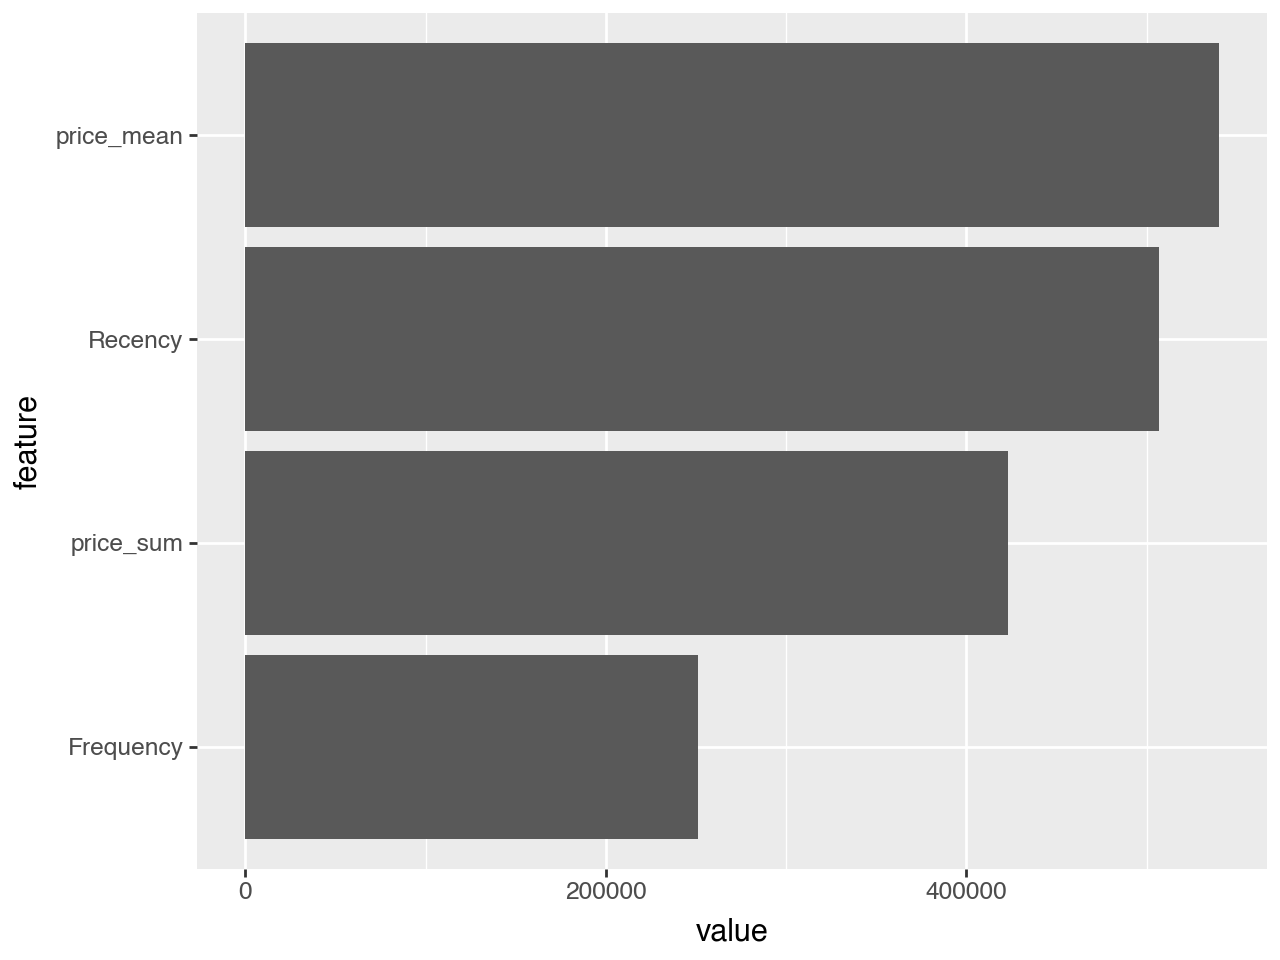

In [55]:
pn.ggplot(spend_pred_importance_df, aes(x = 'feature', y = 'value')) + pn.geom_col() + pn.coord_flip()

2. Importance | Spend Probablity Model

In [57]:
spend_prob_importance = xgb_clf_model.best_estimator_.get_booster().get_score(importance_type = 'gain')

spend_prob_importance_df = pd.DataFrame(data = {'feature' : spend_prob_importance.keys(), 'value' : spend_prob_importance.values()})

spend_prob_importance_df['feature']= pd.Categorical(spend_prob_importance_df['feature']\
                                        ,categories=spend_prob_importance_df.sort_values('value', ascending=True)['feature']\
                                        ,ordered=True)
spend_prob_importance_df = spend_prob_importance_df.sort_values(by='value', ascending=False)

spend_prob_importance_df

,feature,value
2,price_sum,1.360595
0,Recency,1.236652
3,price_mean,1.214760
1,Frequency,1.106321


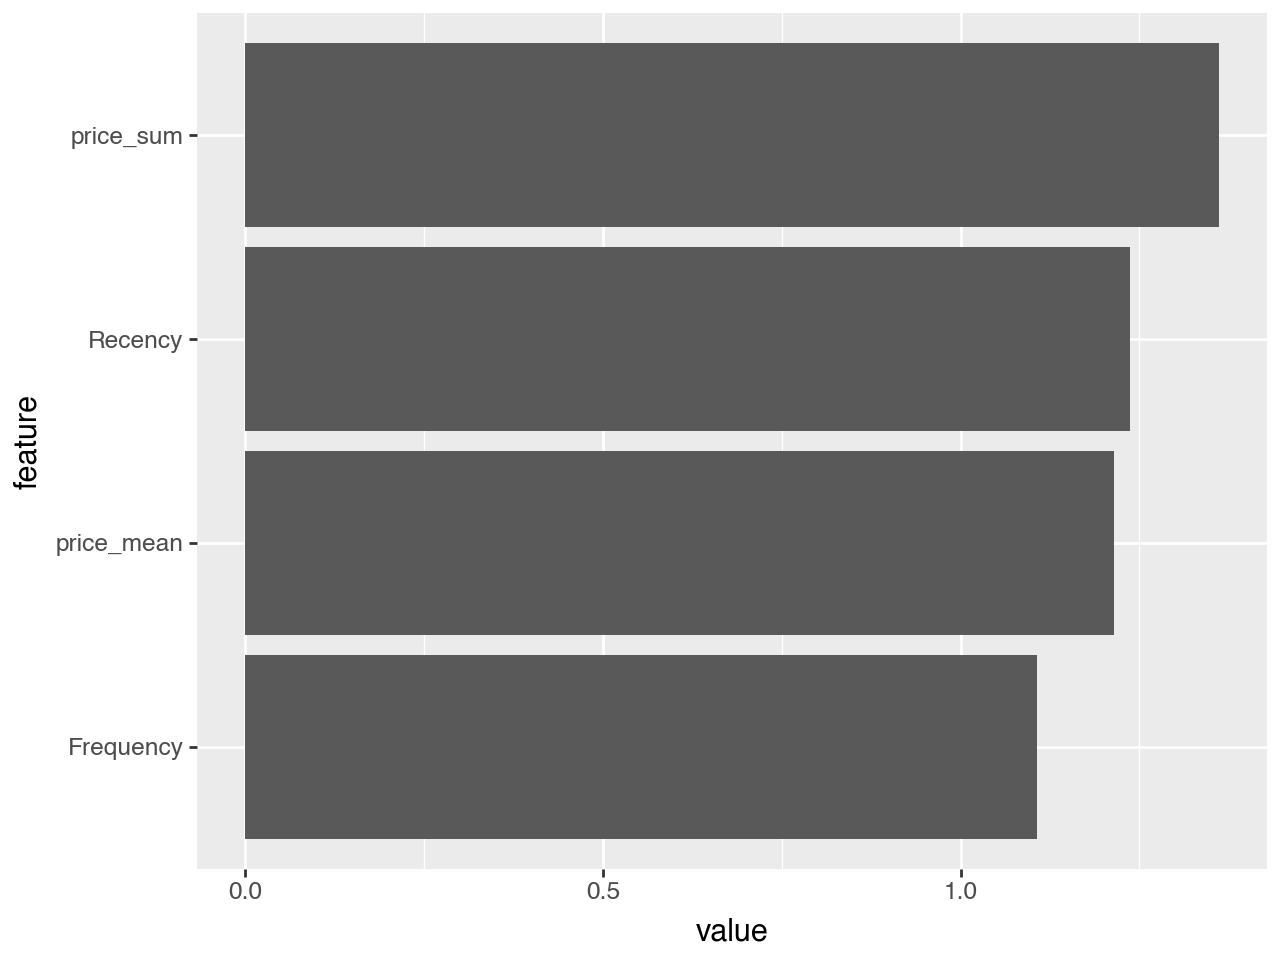

In [58]:
pn.ggplot(spend_prob_importance_df, aes(x = 'feature', y = 'value')) + pn.geom_col() + pn.coord_flip()

## Results of Analysis

Prediction

In [61]:
predictions_df = pd.concat([pd.DataFrame(prediction_reg).set_axis(['pred_spend'], axis = 1)\
                            , pd.DataFrame(prediction_clf)[[1]].set_axis(['pred_prob'], axis = 1)\
                                , features_df.reset_index()], axis = 1)

predictions_df

,pred_spend,pred_prob,customer_id,Recency,Frequency,price_sum,price_mean,spend_90_total,spend_90_flag
0,514.977966,0.912638,1,-7.681563,14,3613.69,258.120714,63.44,1.0
1,500.355713,0.540401,2,-100.434329,6,2099.84,349.973333,0.00,0.0
2,511.724854,0.992548,3,-87.737361,9,3150.22,350.024444,432.69,1.0
3,522.854858,0.734890,4,-9.626620,10,2825.68,282.568000,511.23,1.0
4,518.870483,0.539386,5,-52.077280,10,2555.14,255.514000,742.62,1.0
...,...,...,...,...,...,...,...,...,...
4995,504.884155,0.984349,4996,-7.757326,9,3111.53,345.725556,513.98,1.0
4996,520.983398,0.957189,4997,-9.770775,15,3934.06,262.270667,437.75,1.0
4997,539.276428,0.907569,4998,-56.904988,11,2323.88,211.261818,345.55,1.0
4998,502.306213,0.853858,4999,-6.046458,8,1805.80,225.725000,542.25,1.0


Importance

In [63]:
spend_pred_importance_df.to_pickle('Customer Lifetime Value Project/CLV_GPT/Files/spend_pred_importance_df.pkl')
spend_prob_importance_df.to_pickle('Customer Lifetime Value Project/CLV_GPT/Files/spend_prob_importance_df.pkl')

In [64]:
pd.read_pickle("Customer Lifetime Value Project/CLV_CDnow/Files/spend_pred_importance_df.pkl")

,feature,value
2,price_sum,135610.156250
1,Frequency,73742.445312
3,price_mean,30542.488281
0,Recency,21092.818359


Models

In [66]:
joblib.dump(xgb_reg_model, 'Customer Lifetime Value Project/CLV_GPT/Files/xgb_reg_model.pkl')
joblib.dump(xgb_clf_model, 'Customer Lifetime Value Project/CLV_GPT/Files/xgb_clf_model.pkl')

['Customer Lifetime Value Project/CLV_GPT/Files/xgb_clf_model.pkl']

In [67]:
model = joblib.load('Customer Lifetime Value Project/CLV_CDnow/Files/xgb_clf_model.pkl')
model.predict_proba(X)

array([[0.39575315, 0.60424685],
       [0.54366964, 0.45633036],
       [0.5379801 , 0.46201995],
       ...,
       [0.5518202 , 0.44817978],
       [0.5004972 , 0.4995028 ],
       [0.5518202 , 0.44817978]], dtype=float32)

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns

In [129]:
clusters_df = features_df

In [131]:
from sklearn.preprocessing import StandardScaler

# Standardize the RFM values
scaler = StandardScaler()
clusters_scaled = scaler.fit_transform(clusters_df)

clusters_scaled

array([[ 0.83375159,  1.29655037,  1.19682211,  0.09407705, -1.08449873,
         0.38141234],
       [-1.41733217, -1.25848041, -0.45907252,  1.97538551, -1.23459474,
        -2.62183442],
       [-1.10918031, -0.30034387,  0.68986469,  1.97643236, -0.21087088,
         0.38141234],
       ...,
       [-0.36088723,  0.33841383, -0.21401083, -0.86567825, -0.41703996,
         0.38141234],
       [ 0.87343511, -0.61972271, -0.7807023 , -0.56944602,  0.04834284,
         0.38141234],
       [-0.16992694,  0.33841383,  1.477127  ,  2.01307826, -0.8157029 ,
         0.38141234]])

In [133]:
from sklearn.cluster import KMeans

# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(clusters_scaled)

# Add the cluster labels to the RFM DataFrame
clusters_df['Clusters'] = kmeans.labels_

clusters_scaled

clusters_df.groupby('Clusters').mean()


,Recency,Frequency,price_sum,price_mean,spend_90_total,spend_90_flag
Clusters,,,,,,
0,-114.784712,7.061947,1862.217360,264.882146,550.118407,0.974926
1,-40.512890,9.917208,2516.480114,253.710537,0.000000,0.000000
2,-28.820456,12.667251,3422.453415,273.822554,576.008187,0.998830
3,-29.114586,8.589178,1970.206999,232.227067,626.819699,1.000000


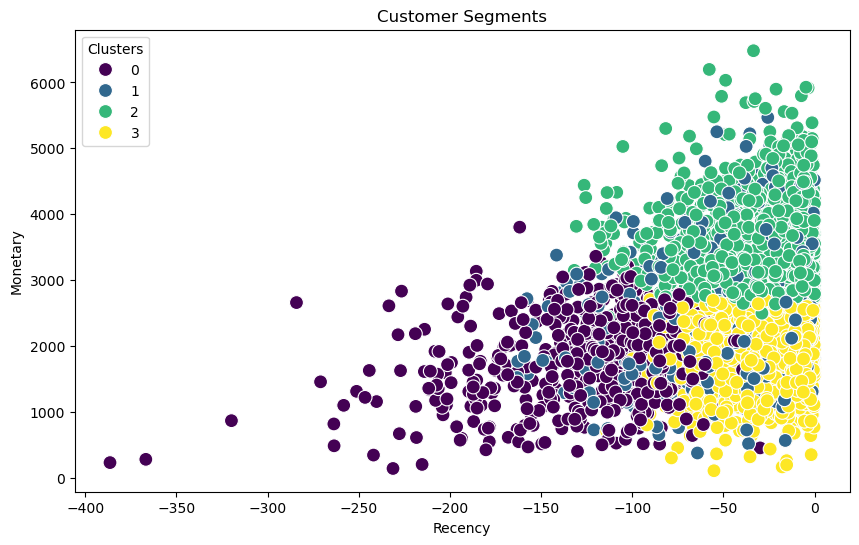

In [135]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='price_sum', hue='Clusters', data=clusters_df, palette='viridis', s=100)
plt.title('Customer Segments')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()

##### Analysis Suggestions:

1. Customer Engagement:
- Cluster 1: Since customers in this cluster have a high spend but no activity in the last 90 days, they might require re-engagement strategies such as targeted promotions or personalized offers to reactivate them.

2. High-Value Customers:
- Cluster 2 and Cluster 3: These clusters contain high-value customers who are very active. Focus on retaining these customers with loyalty programs, exclusive deals, and excellent customer service.

3. Recently Active Customers:
- Cluster 0: Customers in this cluster are relatively recent and active. Continue engaging them with regular communications and promotions to maintain their activity levels.

### Use Case 

##### 1. WHICH CUSTOMERS HAVE THE HIGHEST SPEND PROBABILITY IN THE NEXT 90 DAYS?
   - target for new products similar to what they have purchased in the past

In [70]:
predictions_df.sort_values('pred_prob', ascending = False)

,pred_spend,pred_prob,customer_id,Recency,Frequency,price_sum,price_mean,spend_90_total,spend_90_flag
2112,507.230682,0.998307,2113,-113.169132,16,2446.02,152.876250,114.56,1.0
1648,384.905640,0.998216,1649,-0.288808,4,773.62,193.405000,114.49,1.0
2455,513.703430,0.998085,2456,-13.116933,4,756.33,189.082500,601.45,1.0
3473,527.171997,0.997846,3474,-4.272384,4,1409.93,352.482500,392.86,1.0
3436,534.284363,0.997801,3437,-1.926725,4,864.23,216.057500,1366.37,1.0
...,...,...,...,...,...,...,...,...,...
4872,482.529755,0.126791,4873,-37.207072,6,729.19,121.531667,0.00,0.0
4820,491.922485,0.124956,4821,-149.088634,5,1783.82,356.764000,0.00,0.0
986,521.990784,0.106105,987,-136.065972,12,2968.04,247.336667,0.00,0.0
2967,482.788849,0.090093,2968,-85.381887,5,660.97,132.194000,0.00,0.0


##### 2. WHICH CUSTOMERS HAVE RECENTLY PURCHASED, BUT UNLIKELY TO BUY?
   - Incentivize actions to increase probability
   - Provide discounts, Gamify(Rewards, Referral Bonus), Notifications

In [72]:
discount_cust_df = predictions_df[predictions_df['Recency'] > -90]
discount_cust_df.add(predictions_df[predictions_df['pred_prob'] > -0.20])
discount_cust_df.sort_values('pred_prob', ascending = False)

,pred_spend,pred_prob,customer_id,Recency,Frequency,price_sum,price_mean,spend_90_total,spend_90_flag
1648,384.905640,0.998216,1649,-0.288808,4,773.62,193.405000,114.49,1.0
2455,513.703430,0.998085,2456,-13.116933,4,756.33,189.082500,601.45,1.0
3473,527.171997,0.997846,3474,-4.272384,4,1409.93,352.482500,392.86,1.0
3436,534.284363,0.997801,3437,-1.926725,4,864.23,216.057500,1366.37,1.0
3319,499.537445,0.997333,3320,-49.177315,10,1139.29,113.929000,196.21,1.0
...,...,...,...,...,...,...,...,...,...
998,512.880066,0.155094,999,-43.256713,14,4176.42,298.315714,0.00,0.0
86,485.463135,0.146496,87,-51.686134,13,2601.40,200.107692,0.00,0.0
4872,482.529755,0.126791,4873,-37.207072,6,729.19,121.531667,0.00,0.0
2967,482.788849,0.090093,2968,-85.381887,5,660.97,132.194000,0.00,0.0


##### 3. MISSED OPPORTUNITY---BIG SPENDERS TO LOOK OUT FOR!
   - Send bundle offers
   - Focus on missed opportunities

In [123]:
predictions_df[predictions_df['spend_90_total'] == 0.0].sort_values('pred_prob', ascending = False)

,pred_spend,pred_prob,customer_id,Recency,Frequency,price_sum,price_mean,spend_90_total,spend_90_flag
2442,519.697449,0.929319,2443,-29.372245,13,3512.34,270.180000,0.0,0.0
4231,523.589844,0.921521,4232,-6.621134,12,2519.48,209.956667,0.0,0.0
1250,527.895447,0.903845,1251,-17.541030,11,2412.08,219.280000,0.0,0.0
3814,530.840881,0.901178,3815,-7.155995,7,1490.77,212.967143,0.0,0.0
2195,515.618042,0.899337,2196,-40.325856,12,3067.39,255.615833,0.0,0.0
...,...,...,...,...,...,...,...,...,...
4872,482.529755,0.126791,4873,-37.207072,6,729.19,121.531667,0.0,0.0
4820,491.922485,0.124956,4821,-149.088634,5,1783.82,356.764000,0.0,0.0
986,521.990784,0.106105,987,-136.065972,12,2968.04,247.336667,0.0,0.0
2967,482.788849,0.090093,2968,-85.381887,5,660.97,132.194000,0.0,0.0
